In [11]:
import xarray as xr
import datetime as dt
import pandas as pd
from datetime import timedelta
from opendrift.readers import reader_netCDF_CF_generic_360
from opendrift.readers import reader_global_landmask
from opendrift.models.oceandrift import OceanDrift
import os, requests
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.3,-122.2)
    ax.set_ylim(37.5,38.1)
    return(fig, ax)

## Model Setup ##

__1. Create the Model Object__

We will be using the OceanDrift model, which simulates ocean surface drifting, forced by surface currents, wind, and/or stokes drift.

In [3]:
o = OceanDrift(loglevel=20) # Setting the log level will give the user different amounts of info (0=Debug (all), 20=Minimum, 50=None)

12:41:33 INFO: OpenDriftSimulation initialised (version 1.3.2)


__Create readers for forcing the model__

There are a couple of different types of readers. Here we will be using the `reader_netCDF_CF_generic` class and the `reader_global_landmask`.

__`reader_netCDF_CF_generic`__: Takes any CF-compliant netCDF file (including a thredds endpoint). Because the CF name for surface current velocities are: 'x_sea_water_velocity' and 'y_sea_water_velocity', the reader is able to identify the data.

__`reader_global_landmask`__ will create a landmask from the __Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG)__ dataset.

In [4]:
reader_landmask = reader_global_landmask.Reader(
                       extent=[-123.99,  -122.177032, 37.244221, 38.233120])  # lonmin, lonmax, latmin, latmax
reader_roms = reader_netCDF_CF_generic_360.Reader("http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc")
print(reader_roms)

12:41:41 INFO: Opening dataset: http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc
12:41:41 INFO: Opening file with Dataset
12:41:49 INFO: Variable x_sea_water_velocity will be rotated from eastward_sea_water_velocity
12:41:49 INFO: Variable y_sea_water_velocity will be rotated from northward_sea_water_velocity


Reader: http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: -127.500000   xmax: -117.000000   step: 0.0299988   numx: 351
  ymin: 31.299999   ymax: 43.000000   step: 0.0300007   numy: 390
  Corners (lon, lat):
    (-127.50,  43.00)  (-117.00,  43.00)
    (-127.50,  31.30)  (-117.00,  31.30)
Vertical levels [m]: 
  [   -0.   -10.   -20.   -30.   -40.   -50.   -75.  -100.  -150.  -200.
  -300.  -400.  -500. -1000.]
Available time range:
  start: 2017-10-22 00:00:00   end: 2020-10-19 03:00:00   step: 1:00:00
    26236 times (2670 missing)
Variables:
  time
  sea_water_practical_salinity
  sea_water_temperature
  eastward_sea_water_velocity
  northward_sea_water_velocity
  water_surface_height_above_reference_datum
  x_sea_water_velocity
  y_sea_water_velocity



__3. Add readers to model__

Data readers can be added in an hierarchical manner, from highest to lowest prioity.

In [5]:
o.add_reader([reader_landmask,reader_roms])

__4. Seeding the Model__

There are a several different ways to seed data, we can supply a shape file, a radius, a line etc.

From the tutorial:
```
Note that the radius is not an absolute boundary within which elements will be seeded, but one standard deviation of a normal distribution in space. Thus about 68% of elements will be seeded within this radius, with more elements near the center. By default, elements are seeded at the surface (z=0)
```

Here we could also use the OilDrift model if we wanted to simulate oils (or other density fluids).

In [6]:
noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?date=recent&station=9414290&product=predictions&interval=hilo&datum=mllw&units=metric&time_zone=gmt&application=web_services&format=json"
r = requests.get(noaa_api_request)
df = pd.DataFrame(r.json()['predictions'])
df['t'] = pd.to_datetime(df["t"])
high_tides = df.query("type=='H'")['t']

In [7]:
high_tides

1    2020-10-14 04:30:00
3    2020-10-14 17:39:00
5    2020-10-15 05:28:00
7    2020-10-15 18:12:00
9    2020-10-16 06:25:00
11   2020-10-16 18:46:00
Name: t, dtype: datetime64[ns]

In [23]:
start_time = dt.datetime(2020,10,14,4,30,0)

o.seed_elements(lon=-122.65, lat=37.8, number=500, radius=1000,
                time=start_time)

__5. Setting other configurations__

There are a bunch of ways to configure the model, how it reflects off of the shoreline, the advection schemes, other forcings etc.

Use `o.list_configspec()` to view the current settings

In [24]:
base_folder= "Data/model_output/"
out_fname = "sf_bay_" + start_time.strftime("%Y%m%dT%H%M%S")

o.set_config('general:coastline_action', 'stranding') 
o.set_config('drift:scheme', 'runge-kutta4')
o.set_config('general:time_step_minutes', 15)
o.set_config('drift:stokes_drift', False)
# Run model
o.run(duration=timedelta(hours=48), time_step=timedelta(minutes=15)) #
# o.run(duration=timedelta(hours=48), outfile=os.path.join(base_folder,out_fname+"_CAROMS2.nc")) #

13:18:15 INFO: Config validation OK
13:18:15 INFO: Fallback values will be used for the following variables which have no readers: 
13:18:15 INFO: 	x_wind: 0.000000
13:18:15 INFO: 	y_wind: 0.000000
13:18:15 INFO: 	upward_sea_water_velocity: 0.000000
13:18:15 INFO: 	ocean_vertical_diffusivity: 0.000000
13:18:15 INFO: 	sea_surface_wave_significant_height: 0.000000
13:18:15 INFO: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
13:18:15 INFO: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
13:18:15 INFO: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
13:18:15 INFO: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
13:18:15 INFO: 	surface_downward_x_stress: 0.000000
13:18:15 INFO: 	surface_downward_y_stress: 0.000000
13:18:15 INFO: 	turbulent_kinetic_energy: 0.000000
13:18:15 INFO: 	turbulent_generic_length_scale: 0.000000
13:18:15 INFO: 	sea_floor_depth_below_sea_level: 10000.000000
13:18:15 INFO: Using existing 

13:18:16 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:16 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:16 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:16 INFO: 2020-10-14 06:45:00 - step 10 of 192 - 500 active elements (0 deactivated)
13:18:16 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:16 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:17 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:17 INFO: 2020-10-14 09:00:00 - step 19 of 192 - 500 active elements (0 deactivated)
13:18:17 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:17 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:17 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:17 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:18 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:18 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:18 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:18 INFO: 2020-10-14 11:30:00 - step 29 of 192 - 500 active elements (0 deactivated)
13:18:18 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:18 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:19 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:19 INFO: 2020-10-14 13:45:00 - step 38 of 192 - 500 active elements (0 deactivated)
13:18:19 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:19 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:19 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:19 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:20 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:20 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:20 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:20 INFO: 2020-10-14 16:15:00 - step 48 of 192 - 500 active elements (0 deactivated)
13:18:20 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:20 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:22 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:22 INFO: 2020-10-14 18:30:00 - step 57 of 192 - 500 active elements (0 deactivated)
13:18:22 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:22 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:22 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:22 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:23 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:23 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:23 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:23 INFO: 2020-10-14 21:00:00 - step 67 of 192 - 500 active elements (0 deactivated)
13:18:23 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:23 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:25 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:25 INFO: 2020-10-14 23:15:00 - step 76 of 192 - 500 active elements (0 deactivated)
13:18:25 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:25 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:25 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:25 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:26 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:26 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:26 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:26 INFO: 2020-10-15 01:45:00 - step 86 of 192 - 500 active elements (0 deactivated)
13:18:26 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:26 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:28 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:28 INFO: 2020-10-15 04:00:00 - step 95 of 192 - 500 active elements (0 deactivated)
13:18:28 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:28 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:28 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:28 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover eleme

13:18:29 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:29 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:29 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:29 INFO: 2020-10-15 06:30:00 - step 105 of 192 - 500 active elements (0 deactivated)
13:18:29 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:30 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:31 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:31 INFO: 2020-10-15 08:45:00 - step 114 of 192 - 500 active elements (0 deactivated)
13:18:31 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:31 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:31 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:31 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:33 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:33 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:33 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:33 INFO: 2020-10-15 11:15:00 - step 124 of 192 - 500 active elements (0 deactivated)
13:18:33 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:33 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:34 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:34 INFO: 2020-10-15 13:30:00 - step 133 of 192 - 500 active elements (0 deactivated)
13:18:34 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:34 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:34 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:34 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:36 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:36 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:36 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:36 INFO: 2020-10-15 16:00:00 - step 143 of 192 - 500 active elements (0 deactivated)
13:18:36 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:36 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:37 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:37 INFO: 2020-10-15 18:15:00 - step 152 of 192 - 500 active elements (0 deactivated)
13:18:37 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:37 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:37 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:37 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:39 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:39 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:39 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:39 INFO: 2020-10-15 20:45:00 - step 162 of 192 - 500 active elements (0 deactivated)
13:18:39 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:39 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:40 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:40 INFO: 2020-10-15 23:00:00 - step 171 of 192 - 500 active elements (0 deactivated)
13:18:40 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:41 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:41 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:41 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:42 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:42 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:42 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:42 INFO: 2020-10-16 01:30:00 - step 181 of 192 - 500 active elements (0 deactivated)
13:18:42 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:42 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

13:18:44 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:44 INFO: 2020-10-16 03:45:00 - step 190 of 192 - 499 active elements (1 deactivated)
13:18:44 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:44 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:44 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover element positions within timestep. Buffer size (4) must be increased.
13:18:44 WARNING: Data block from http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc not large enough to cover elem

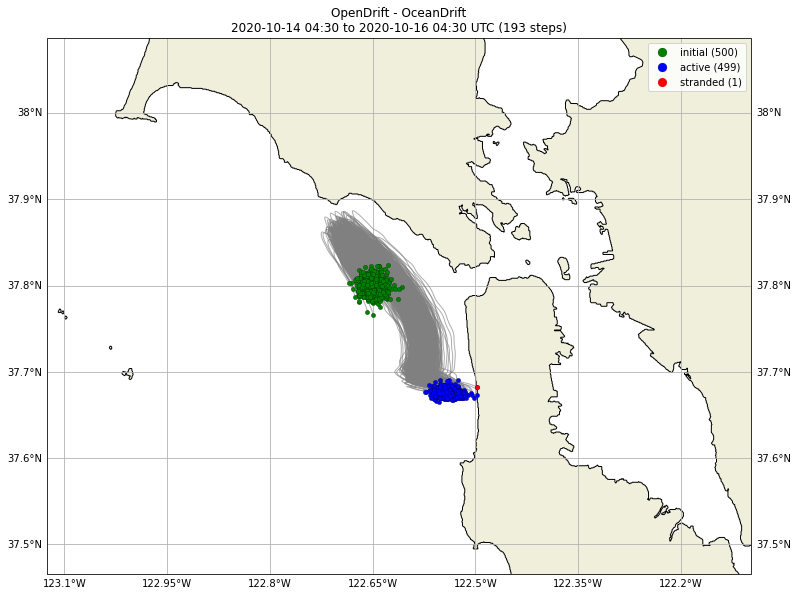

(<GeoAxesSubplot:title={'center':'OpenDrift - OceanDrift\n2020-10-14 04:30 to 2020-10-16 04:30 UTC (193 steps)'}>,
 <module 'matplotlib.pyplot' from '/home/pdaniel/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

In [25]:
o.plot(density=True)


13:19:23 WARNING: plotting fast. this will make your plots less accurate.
  u, v = self.projection.transform_vectors(t, x, y, u, v)

  u, v = self.projection.transform_vectors(t, x, y, u, v)

13:19:27 INFO: Saving animation to Figures/GG_example-recent-roms2.mp4...
[libx264 @ 0x559ae6635880] height not divisible by 2 (792x605)
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height

13:19:29 INFO: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '792x605', '-pix_fmt', 'rgba', '-r', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-b', '1800k', '-profile:v', 'baseline', '-pix_fmt', 'yuv420p', '-an', '-y', 'Figures/GG_example-recent-roms2.mp4']' returned non-zero exit status 1.


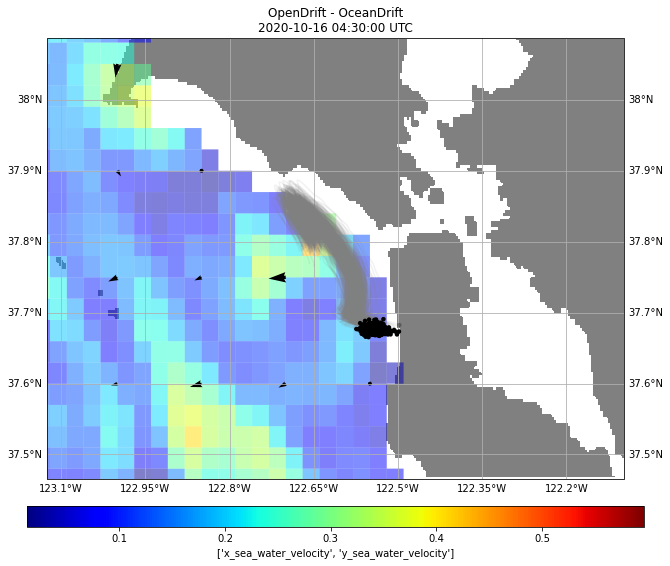

In [26]:
o.animation(background=['x_sea_water_velocity',"y_sea_water_velocity"],
             legend_loc='upper center', fast=True,  filename='Figures/GG_example-recent-roms2.mp4',show_trajectories=True, density=False)

In [13]:
o.reset()

In [12]:
extent=[-123.99,  -122.177032, 37.244221, 38.233120]
ds = xr.open_dataset("http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc")
ds['lon'] = ((ds['lon'] + 180) % 360)-180
# fig, ax = make_map()
# ds.isel(depth = 0,time=-1)['u'].plot(ax=ax)

In [ ]:
ds.sel(time=start_time_time,)

In [23]:
o.animation(background=[],
             legend_loc='upper center', fast=True,  filename='Figures/GG_example-high-tide_roms',show_trajectories=True, density=True)

<IPython.core.display.Javascript object>

IndexError: list index out of range

In [ ]:
o.plot(density=True, filename='Figures/testing_plot2.png')
plt.show()

In [ ]:
o.write_netcdf_density_map('Data/model_output/diffusion_density_large.nc',pixelsize_m=1000)


In [ ]:
o.reset()

In [30]:
o.get_config

TypeError: get_configspec() missing 1 required positional argument: 'key'

In [ ]:
# noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date=20201010&end_date=20201013&datum=MLLW&station=9414290&time_zone=GMT&units=english&format=json"
noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?date=recent&station=9414290&product=water_level&datum=mllw&units=metric&time_zone=gmt&application=web_services&format=json"
r = requests.get(noaa_api_request)
df = pd.DataFrame(r.json()['data'])
df['t'] = pd.to_datetime(df["t"])
df['v'] = df['v'].astype(float)
df['s'] = df['s'].astype(float)
df.index = df['t']

# high_tides = df.query("type=='H'")['t']
noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?date=recent&station=9414290&product=predictions&interval=hilo&datum=mllw&units=metric&time_zone=gmt&application=web_services&format=json"
r = requests.get(noaa_api_request)
ht = pd.DataFrame(r.json()['predictions'])
ht['v'] = ht['v'].astype(float)
ht['t'] = pd.to_datetime(ht["t"])
high_tides = ht.query("type=='H'")


### Checking tides with HFR data

In [15]:
extent=[-123.99,  -122.177032, 37.244221, 38.233120]
ds = xr.open_dataset("http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc")
ds['lon'] = ((ds['lon'] + 180) % 360)-180

<IPython.core.display.Javascript object>


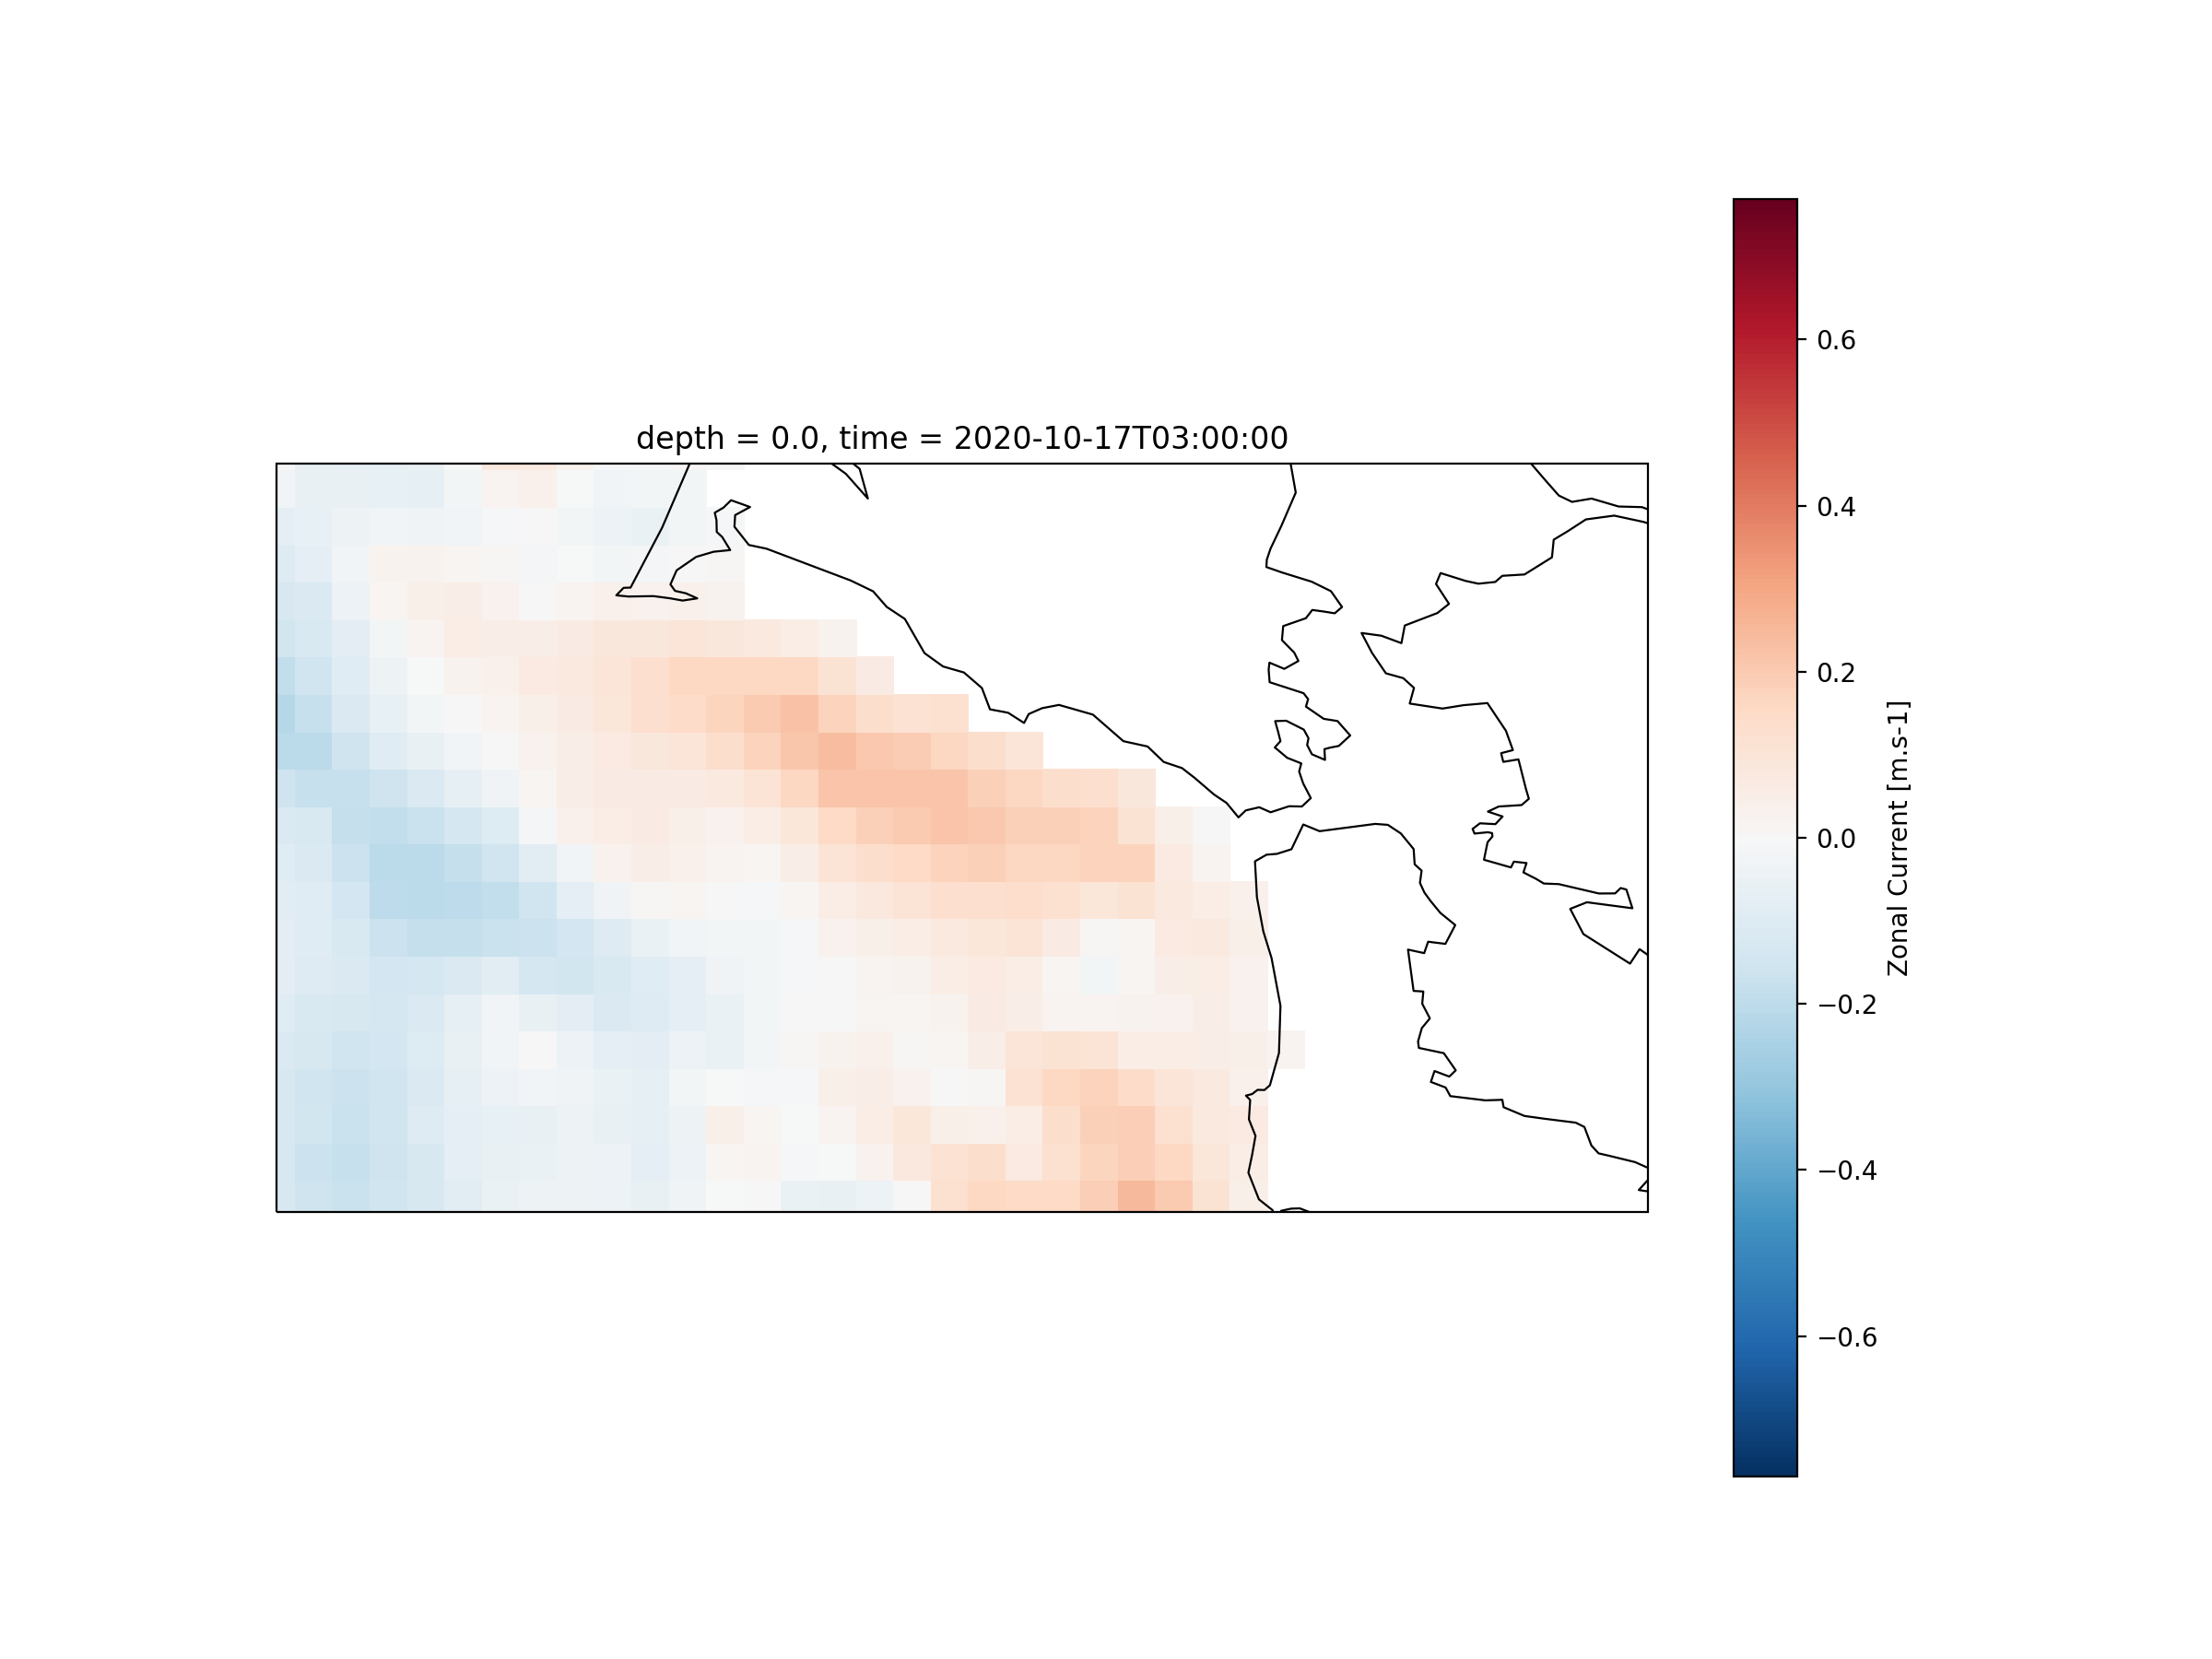

In [24]:
extent=[-123.99,  -122.177032, 37.244221, 38.233120]
ds = xr.open_dataset("http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc")
ds['lon'] = ((ds['lon'] + 180) % 360)-180
fig, ax = make_map()
ds.isel(depth = 0,time=-1)['u'].plot(ax=ax)

In [19]:
ds

<xarray.Dataset>
Dimensions:  (depth: 14, lat: 391, lon: 351, time: 23548)
Coordinates:
  * depth    (depth) float32 0.0 10.0 20.0 30.0 ... 300.0 400.0 500.0 1000.0
  * lat      (lat) float32 31.3 31.33 31.359999 31.39 ... 42.91 42.94 42.97 43.0
  * lon      (lon) float32 -127.5 -127.47 -127.44 ... -117.06 -117.03 -117.0
  * time     (time) datetime64[ns] 2017-10-22 ... 2020-10-17T03:00:00
Data variables:
    salt     (time, depth, lat, lon) float32 ...
    temp     (time, depth, lat, lon) float32 ...
    u        (time, depth, lat, lon) float32 ...
    v        (time, depth, lat, lon) float32 ...
    zeta     (time, lat, lon) float32 ...
Attributes:
    type:                     ROMS REAL TIME FORECASTING
    fileid:                   SOUTH CALIFORNIA BIGHT
    history:                  Wed Oct 14 04:05:45 2020: ncatted -O -aunits,ti...
    title:                    California ROMS Forecast (3km)
    summary:                  The California ROMS model extends from just nor...
    keywords:                 OCEANS; SALINITY/DENSITY; SALINITY, OCEANS; OCE...
    keywords_vocabulary:      Olsen, L.M., G. Major, K. Shein, J. Scialdone, ...
    standard_name_vocabular:  CF-Standard Names 27
    comment:                  The ROMS model is described in detail at: http:...
    acknowledgement:          This model is operated by UCLA and Remote Sensi...
    metadata_link:            https://www.cencoos.org/data/models/roms/ca
    cdm_data_type:            grid
    creator_name:             Dr. Yi Chao
    creator_url:              http://remotesensingsolutions.com/team/
    creator_email:            ychao@remotesensingsolutions.com
    project:                  CeNCOOS
    publisher_name:           Central and Northern California Ocean Observing...
    publisher_url:            https://www.cencoos.org